In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

from tqdm import tqdm
from glob import glob
import os
import json 
import timm
import torch
from torch import nn
from torchvision import models
from torch.utils.data import Dataset
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.optim import AdamW

from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split, StratifiedKFold
import albumentations as A

In [2]:
# 변수 설명 csv 파일 참조
crop = {'1':'딸기','2':'토마토','3':'파프리카','4':'오이','5':'고추','6':'시설포도'}
disease = {'1':{'a1':'딸기잿빛곰팡이병','a2':'딸기흰가루병','b1':'냉해피해','b6':'다량원소결핍 (N)','b7':'다량원소결핍 (P)','b8':'다량원소결핍 (K)'},
           '2':{'a5':'토마토흰가루병','a6':'토마토잿빛곰팡이병','b2':'열과','b3':'칼슘결핍','b6':'다량원소결핍 (N)','b7':'다량원소결핍 (P)','b8':'다량원소결핍 (K)'},
           '3':{'a9':'파프리카흰가루병','a10':'파프리카잘록병','b3':'칼슘결핍','b6':'다량원소결핍 (N)','b7':'다량원소결핍 (P)','b8':'다량원소결핍 (K)'},
           '4':{'a3':'오이노균병','a4':'오이흰가루병','b1':'냉해피해','b6':'다량원소결핍 (N)','b7':'다량원소결핍 (P)','b8':'다량원소결핍 (K)'},
           '5':{'a7':'고추탄저병','a8':'고추흰가루병','b3':'칼슘결핍','b6':'다량원소결핍 (N)','b7':'다량원소결핍 (P)','b8':'다량원소결핍 (K)'},
           '6':{'a11':'시설포도탄저병','a12':'시설포도노균병','b4':'일소피해','b5':'축과병'}}
risk = {'1':'초기','2':'중기','3':'말기'}

In [3]:
label_description = {}
for key, value in disease.items():
    label_description[f'{key}_00_0'] = f'{crop[key]}_정상'
    for disease_code in value:
        for risk_code in risk:
            label = f'{key}_{disease_code}_{risk_code}'
            label_description[label] = f'{crop[key]}_{disease[key][disease_code]}_{risk[risk_code]}'
list(label_description.items())[:10]

[('1_00_0', '딸기_정상'),
 ('1_a1_1', '딸기_딸기잿빛곰팡이병_초기'),
 ('1_a1_2', '딸기_딸기잿빛곰팡이병_중기'),
 ('1_a1_3', '딸기_딸기잿빛곰팡이병_말기'),
 ('1_a2_1', '딸기_딸기흰가루병_초기'),
 ('1_a2_2', '딸기_딸기흰가루병_중기'),
 ('1_a2_3', '딸기_딸기흰가루병_말기'),
 ('1_b1_1', '딸기_냉해피해_초기'),
 ('1_b1_2', '딸기_냉해피해_중기'),
 ('1_b1_3', '딸기_냉해피해_말기')]

In [4]:
# ============= add
labels = pd.read_csv('./data/train.csv')

train_label_encoder = {}
label_cnt = 0
previous_label = '0_00_0'
for i, label in enumerate(tqdm(sorted(labels['label']))) :
    crop_val = label.split('_')[0] # crop
    disease_val = label.split('_')[1] # disease
    risk_val = label.split('_')[2] # risk
    
    tmp_label = f'{crop_val}_{disease_val}_{risk_val}'
    if previous_label != tmp_label :
        train_label_encoder[tmp_label] = label_cnt
        previous_label = tmp_label
        label_cnt += 1
        
train_label_decoder = {val : key for key, val in train_label_encoder.items()}
display(train_label_decoder)
display(train_label_encoder)

100%|██████████████████████████████████████████████████████████████████████████| 5767/5767 [00:00<00:00, 961198.14it/s]


{0: '1_00_0',
 1: '2_00_0',
 2: '2_a5_2',
 3: '3_00_0',
 4: '3_a9_1',
 5: '3_a9_2',
 6: '3_a9_3',
 7: '3_b3_1',
 8: '3_b6_1',
 9: '3_b7_1',
 10: '3_b8_1',
 11: '4_00_0',
 12: '5_00_0',
 13: '5_a7_2',
 14: '5_b6_1',
 15: '5_b7_1',
 16: '5_b8_1',
 17: '6_00_0',
 18: '6_a11_1',
 19: '6_a11_2',
 20: '6_a12_1',
 21: '6_a12_2',
 22: '6_b4_1',
 23: '6_b4_3',
 24: '6_b5_1'}

{'1_00_0': 0,
 '2_00_0': 1,
 '2_a5_2': 2,
 '3_00_0': 3,
 '3_a9_1': 4,
 '3_a9_2': 5,
 '3_a9_3': 6,
 '3_b3_1': 7,
 '3_b6_1': 8,
 '3_b7_1': 9,
 '3_b8_1': 10,
 '4_00_0': 11,
 '5_00_0': 12,
 '5_a7_2': 13,
 '5_b6_1': 14,
 '5_b7_1': 15,
 '5_b8_1': 16,
 '6_00_0': 17,
 '6_a11_1': 18,
 '6_a11_2': 19,
 '6_a12_1': 20,
 '6_a12_2': 21,
 '6_b4_1': 22,
 '6_b4_3': 23,
 '6_b5_1': 24}

# Dataset 구현

In [5]:
class CustomDataset(Dataset):
    def __init__(self, files, transforms, mode='train'):
        self.mode = mode
        self.files = files
        self.label_encoder = train_label_encoder #label_encoder
        self.transforms = transforms
        
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, i):
        file = self.files[i]
        file_name = file.split('\\')[-1]
        
        
        # image
        image_path = f'{file}/{file_name}.jpg'
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#         img = cv2.resize(img, dsize=(224, 224), interpolation=cv2.INTER_AREA)
#         img = img.astype(np.float32)/255
        img = self.transforms(image=img)["image"]
        img = img.transpose(2,0,1)
        
        if self.mode == 'train':
            json_path = f'{file}/{file_name}.json'
            with open(json_path, 'r') as f:
                json_file = json.load(f)
            
            crop = json_file['annotations']['crop']
            disease = json_file['annotations']['disease']
            risk = json_file['annotations']['risk']
            label = f'{crop}_{disease}_{risk}'
            
            return {
#                 'img' : torch.tensor(img, dtype=torch.float32),
                'img' : torch.tensor(img, dtype=torch.float32) / 255.0,
                'label' : torch.tensor(self.label_encoder[label], dtype=torch.long)
            }
        else:
            return {
                'img' : torch.tensor(img, dtype=torch.float32)/ 255.0
#                 'img' : torch.tensor(img, dtype=torch.float32)
            }

# Model 선언

In [6]:
import timm
import torch.nn as nn

class ViT(nn.Module):
    def __init__(self):
        super(ViT, self).__init__()
        self.model = timm.create_model('vit_small_patch16_224', num_classes=25, pretrained=True)
        
    def forward(self, inputs):
        output = self.model(inputs)
        return output
    
    
    
    
class pretrained_DeiT(nn.Module):
    def __init__(self):
        super(pretrained_DeiT, self).__init__()
        self.model = timm.create_model('deit_small_patch16_224', num_classes=38, pretrained=False)

    def forward(self, inputs):
        output = self.model(inputs)
        return output
    
class Deit(nn.Module) :
    def __init__(self, model_path, test=False) :
        super(Deit, self).__init__()
        self.pre_model = pretrained_DeiT()
        if test == False :
            self.pre_model.load_state_dict(torch.load(model_path, map_location=device))
        
        self.fc = nn.Linear(38, 25)
        
    def forward(self, x) :
        x = self.pre_model(x)
        x = self.fc(x)
        return x
    
    

    
class pretrained_EffiV2S(nn.Module):
    def __init__(self):
        super(pretrained_EffiV2S, self).__init__()
        self.model = timm.create_model('efficientnetv2_rw_s', num_classes=38, pretrained=False)
    
    def forward(self, inputs):
        output = self.model(inputs)
        return output

class EffiV2S(nn.Module) :
    def __init__(self, model_path, test=False) :
        super(EffiV2S, self).__init__()
        self.pre_model = pretrained_EffiV2S()
        if test == False :
            self.pre_model.load_state_dict(torch.load(model_path, map_location=device))
        
        self.fc = nn.Linear(38, 25)
        
    def forward(self, x) :
        x = self.pre_model(x)
        x = self.fc(x)
        return x    

# Hyperparmeter 선언

In [7]:
device = torch.device("cuda:0")#("cpu")
batch_size = 16
class_n = len(train_label_encoder)
learning_rate = 1e-4
epochs = 25
model_path = './model/public_vill_50k_pretrain_Deit_S16patch224_25E.pt'
save_path = 'public_vill_50k_pretrain_Deit_S16patch224_25E.pt'
fold_n = 4
early_stopping_cnt = 4

# Image Transform

In [8]:
# train_transforms = A.Compose([
#                 A.Resize(224 ,224),
#                 A.OneOf([
#                     A.Rotate(),
#                     A.HorizontalFlip(),
#                     A.VerticalFlip()
#                 ], p=1)
#             ])

# val_transforms = A.Compose([
#     A.Resize(224,224)
# ])
train_transforms = A.Compose([
                A.Resize(224 ,224),
                A.OneOf([
                    A.Rotate(),
                    A.HorizontalFlip(),
                    A.VerticalFlip()
                ], p=1)
            ])

val_transforms = A.Compose([
    A.Resize(224, 224)
])

# CutMix

In [9]:
def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)
 
    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2

# Training

In [10]:
def accuracy_function(real, pred):    
    real = real.cpu()
    pred = torch.argmax(pred, dim=1).cpu()
    score = f1_score(real, pred, average='macro')
    return score

def train_step(batch_item, training):
    img = batch_item['img'].to(device)
    label = batch_item['label'].to(device)
    
    lam = np.random.beta(1.0, 1.0)
    
    if training is True:
        model.train()
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            # add - cutmix
            rand_index = torch.randperm(img.size()[0])
            target_a = label
            target_b = label[rand_index]
            bbx1, bby1, bbx2, bby2 = rand_bbox(img.size(), lam)
            img[:, :, bbx1:bbx2, bby1:bby2] = img[rand_index, :, bbx1:bbx2, bby1:bby2]
            lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (img.size()[-1] * img.size()[-2]))
            
            output = model(img)
            loss = criterion(output, target_a) * lam + criterion(output, target_b) * (1. - lam)
            
#             output = model(img, csv_feature)
#             loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        score = accuracy_function(label, output)
        return loss, score
    else:
        model.eval()
        with torch.no_grad():
            output = model(img)
            loss = criterion(output, label)
        score = accuracy_function(label, output)
        return loss, score

# Model, Loss, Optim

In [11]:
# model = ViT()
model = Deit(model_path)
# model = EffiV2S(model_path)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# optimizer = AdamW(model.parameters(), lr=learning_rate)
# scheduler = CosineAnnealingLR(optimizer, T_max=5, eta_min=1e-5)

criterion = nn.CrossEntropyLoss()



# Label

In [12]:
json_path = glob('./data/train/*/*.json')

labels = []
for path in tqdm(json_path) :
    json_file = json.load(open(path, 'r'))
    
    crop = json_file['annotations']['crop']
    disease = json_file['annotations']['disease']
    risk = json_file['annotations']['risk']
    
    label = f'{crop}_{disease}_{risk}'
    labels.append(train_label_encoder[label])

100%|█████████████████████████████████████████████████████████████████████████████| 5767/5767 [00:19<00:00, 291.84it/s]


In [13]:
data_list = glob('./data/train/*')
label_list = labels

kfold = StratifiedKFold(n_splits=fold_n, random_state=13, shuffle=True)

In [14]:
for k, (fold_train, fold_val) in enumerate(kfold.split(data_list, label_list), 1) :
#     model = EffiV2S(model_path)
    model = Deit(model_path)
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#     scheduler = CosineAnnealingLR(optimizer, T_max=5, eta_min=1e-5)
    criterion = nn.CrossEntropyLoss()
    
    train_data_list = []
    val_data_list = []
    
    for k_train in fold_train :
        train_data_list.append(data_list[k_train])
    
    for k_val in fold_val :
        val_data_list.append(data_list[k_val])
    
    print(f"\n\n\n===== k_fold : {k} / {fold_n} =====")
    train_dataset = CustomDataset(train_data_list, train_transforms)
    val_dataset = CustomDataset(val_data_list, val_transforms)
    
    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    loss_plot, val_loss_plot = [], []
    metric_plot, val_metric_plot = [], []
    
    early_stopping = 0
    for epoch in range(epochs):
        total_loss, total_val_loss = 0, 0
        total_acc, total_val_acc = 0, 0

        tqdm_dataset = tqdm(enumerate(train_dataloader))
        training = True
        for batch, batch_item in tqdm_dataset:
            batch_loss, batch_acc = train_step(batch_item, training)
            total_loss += batch_loss
            total_acc += batch_acc

            tqdm_dataset.set_postfix({
                'Epoch': epoch + 1,
                'Loss': '{:06f}'.format(batch_loss.item()),
                'Mean Loss' : '{:06f}'.format(total_loss/(batch+1)),
                'Mean F-1' : '{:06f}'.format(total_acc/(batch+1))
            })
        loss_plot.append(total_loss/(batch+1))
        metric_plot.append(total_acc/(batch+1))

        tqdm_dataset = tqdm(enumerate(val_dataloader))
        training = False
        for batch, batch_item in tqdm_dataset:
            batch_loss, batch_acc = train_step(batch_item, training)
            total_val_loss += batch_loss
            total_val_acc += batch_acc

            tqdm_dataset.set_postfix({
                'Epoch': epoch + 1,
                'Val Loss': '{:06f}'.format(batch_loss.item()),
                'Mean Val Loss' : '{:06f}'.format(total_val_loss/(batch+1)),
                'Mean Val F-1' : '{:06f}'.format(total_val_acc/(batch+1))
            })
        val_loss_plot.append(total_val_loss/(batch+1))
        val_metric_plot.append(total_val_acc/(batch+1))
        
        # scheduler
#         scheduler.step()
        
        if np.max(val_metric_plot) == val_metric_plot[-1]:
            torch.save(model.state_dict(), f'{k}_{save_path}')
            early_stopping = 0
    
        elif np.max(val_metric_plot) > val_metric_plot[-1]: 
            early_stopping += 1
            print(f"Early Stopping Step : [{early_stopping} / 4]")

        if early_stopping == early_stopping_cnt :
            print("== Early Stop ==")
            break




===== k_fold : 1 / 4 =====


271it [01:10,  3.83it/s, Epoch=1, Loss=1.797857, Mean Loss=1.625625, Mean F-1=0.400644]
91it [00:16,  5.54it/s, Epoch=1, Val Loss=0.951808, Mean Val Loss=0.541606, Mean Val F-1=0.676932]
271it [01:11,  3.79it/s, Epoch=2, Loss=0.738932, Mean Loss=1.036873, Mean F-1=0.564145]
91it [00:16,  5.45it/s, Epoch=2, Val Loss=0.667667, Mean Val Loss=0.331746, Mean Val F-1=0.771896]
271it [01:11,  3.79it/s, Epoch=3, Loss=0.816275, Mean Loss=0.870355, Mean F-1=0.601045]
91it [00:17,  5.27it/s, Epoch=3, Val Loss=0.214773, Mean Val Loss=0.224626, Mean Val F-1=0.829795]
271it [01:12,  3.71it/s, Epoch=4, Loss=1.004081, Mean Loss=0.773452, Mean F-1=0.653456]
91it [00:17,  5.27it/s, Epoch=4, Val Loss=0.119250, Mean Val Loss=0.191395, Mean Val F-1=0.847021]
271it [01:13,  3.69it/s, Epoch=5, Loss=0.588264, Mean Loss=0.737813, Mean F-1=0.677830]
91it [00:18,  4.81it/s, Epoch=5, Val Loss=0.086757, Mean Val Loss=0.198032, Mean Val F-1=0.834874]


Early Stopping Step : [1 / 4]


271it [01:15,  3.59it/s, Epoch=6, Loss=0.738112, Mean Loss=0.707081, Mean F-1=0.671566]
91it [00:17,  5.15it/s, Epoch=6, Val Loss=0.470200, Mean Val Loss=0.165172, Mean Val F-1=0.874551]
271it [01:14,  3.63it/s, Epoch=7, Loss=1.040160, Mean Loss=0.688261, Mean F-1=0.686446]
91it [00:17,  5.20it/s, Epoch=7, Val Loss=0.026160, Mean Val Loss=0.154560, Mean Val F-1=0.863884]


Early Stopping Step : [1 / 4]


271it [01:15,  3.57it/s, Epoch=8, Loss=0.632869, Mean Loss=0.671605, Mean F-1=0.708846]
91it [00:18,  4.82it/s, Epoch=8, Val Loss=0.129308, Mean Val Loss=0.158260, Mean Val F-1=0.880163]
271it [01:18,  3.46it/s, Epoch=9, Loss=0.517651, Mean Loss=0.641481, Mean F-1=0.736561]
91it [00:19,  4.74it/s, Epoch=9, Val Loss=0.028022, Mean Val Loss=0.141096, Mean Val F-1=0.886365]
271it [01:20,  3.39it/s, Epoch=10, Loss=0.330526, Mean Loss=0.628228, Mean F-1=0.725036]
91it [00:18,  4.88it/s, Epoch=10, Val Loss=0.055315, Mean Val Loss=0.139992, Mean Val F-1=0.888429]
271it [01:19,  3.42it/s, Epoch=11, Loss=0.622490, Mean Loss=0.602991, Mean F-1=0.790535]
91it [00:18,  4.93it/s, Epoch=11, Val Loss=0.064140, Mean Val Loss=0.137953, Mean Val F-1=0.893526]
271it [01:20,  3.37it/s, Epoch=12, Loss=0.752517, Mean Loss=0.611048, Mean F-1=0.771512]
91it [00:18,  4.96it/s, Epoch=12, Val Loss=0.057582, Mean Val Loss=0.124718, Mean Val F-1=0.888550]


Early Stopping Step : [1 / 4]


271it [01:21,  3.31it/s, Epoch=13, Loss=0.479411, Mean Loss=0.599178, Mean F-1=0.762003]
91it [00:19,  4.60it/s, Epoch=13, Val Loss=0.035974, Mean Val Loss=0.126841, Mean Val F-1=0.900468]
271it [01:24,  3.22it/s, Epoch=14, Loss=0.221675, Mean Loss=0.586546, Mean F-1=0.759397]
91it [00:19,  4.63it/s, Epoch=14, Val Loss=0.374732, Mean Val Loss=0.153114, Mean Val F-1=0.879009]


Early Stopping Step : [1 / 4]


271it [01:23,  3.25it/s, Epoch=15, Loss=0.780602, Mean Loss=0.587255, Mean F-1=0.763460]
91it [00:21,  4.31it/s, Epoch=15, Val Loss=0.579096, Mean Val Loss=0.137113, Mean Val F-1=0.899223]


Early Stopping Step : [2 / 4]


271it [01:26,  3.12it/s, Epoch=16, Loss=0.283748, Mean Loss=0.576399, Mean F-1=0.791297]
91it [00:20,  4.34it/s, Epoch=16, Val Loss=0.231493, Mean Val Loss=0.132427, Mean Val F-1=0.902159]
271it [01:27,  3.08it/s, Epoch=17, Loss=1.059636, Mean Loss=0.555388, Mean F-1=0.811405]
91it [00:20,  4.37it/s, Epoch=17, Val Loss=0.072380, Mean Val Loss=0.118225, Mean Val F-1=0.916476]
271it [01:32,  2.93it/s, Epoch=18, Loss=0.298975, Mean Loss=0.595821, Mean F-1=0.766253]
91it [00:21,  4.32it/s, Epoch=18, Val Loss=0.594132, Mean Val Loss=0.166899, Mean Val F-1=0.879238]


Early Stopping Step : [1 / 4]


271it [01:40,  2.71it/s, Epoch=19, Loss=0.621965, Mean Loss=0.549252, Mean F-1=0.799751]
91it [00:24,  3.68it/s, Epoch=19, Val Loss=0.156733, Mean Val Loss=0.129411, Mean Val F-1=0.912090]


Early Stopping Step : [2 / 4]


271it [01:34,  2.87it/s, Epoch=20, Loss=0.627090, Mean Loss=0.556805, Mean F-1=0.780864]
91it [00:23,  3.95it/s, Epoch=20, Val Loss=0.012108, Mean Val Loss=0.164865, Mean Val F-1=0.886488]


Early Stopping Step : [3 / 4]


271it [01:36,  2.80it/s, Epoch=21, Loss=0.546061, Mean Loss=0.579334, Mean F-1=0.742895]
91it [00:23,  3.93it/s, Epoch=21, Val Loss=0.280471, Mean Val Loss=0.117711, Mean Val F-1=0.906162]


Early Stopping Step : [4 / 4]
== Early Stop ==



===== k_fold : 2 / 4 =====


271it [01:10,  3.83it/s, Epoch=1, Loss=1.531899, Mean Loss=1.644949, Mean F-1=0.370998]
91it [00:16,  5.60it/s, Epoch=1, Val Loss=0.291813, Mean Val Loss=0.590363, Mean Val F-1=0.630960]
271it [01:10,  3.82it/s, Epoch=2, Loss=1.005122, Mean Loss=1.039560, Mean F-1=0.560874]
91it [00:16,  5.56it/s, Epoch=2, Val Loss=0.078723, Mean Val Loss=0.319513, Mean Val F-1=0.742048]
271it [01:11,  3.78it/s, Epoch=3, Loss=0.839689, Mean Loss=0.864129, Mean F-1=0.611000]
91it [00:16,  5.59it/s, Epoch=3, Val Loss=0.040547, Mean Val Loss=0.253436, Mean Val F-1=0.807284]
271it [01:12,  3.76it/s, Epoch=4, Loss=0.438864, Mean Loss=0.796199, Mean F-1=0.652169]
91it [00:16,  5.37it/s, Epoch=4, Val Loss=0.020838, Mean Val Loss=0.203387, Mean Val F-1=0.835638]
271it [01:12,  3.76it/s, Epoch=5, Loss=0.831865, Mean Loss=0.764781, Mean F-1=0.654547]
91it [00:16,  5.39it/s, Epoch=5, Val Loss=1.185516, Mean Val Loss=0.237261, Mean Val F-1=0.825828]


Early Stopping Step : [1 / 4]


271it [01:14,  3.65it/s, Epoch=6, Loss=0.720003, Mean Loss=0.718693, Mean F-1=0.675878]
91it [00:17,  5.29it/s, Epoch=6, Val Loss=0.008650, Mean Val Loss=0.221135, Mean Val F-1=0.827163]


Early Stopping Step : [2 / 4]


271it [01:13,  3.67it/s, Epoch=7, Loss=1.005918, Mean Loss=0.669254, Mean F-1=0.734169]
91it [00:17,  5.09it/s, Epoch=7, Val Loss=0.012773, Mean Val Loss=0.186676, Mean Val F-1=0.842175]
271it [01:13,  3.70it/s, Epoch=8, Loss=0.470051, Mean Loss=0.658027, Mean F-1=0.707320]
91it [00:17,  5.13it/s, Epoch=8, Val Loss=0.021722, Mean Val Loss=0.180850, Mean Val F-1=0.841452]


Early Stopping Step : [1 / 4]


271it [01:16,  3.53it/s, Epoch=9, Loss=0.052262, Mean Loss=0.654865, Mean F-1=0.707900]
91it [00:17,  5.06it/s, Epoch=9, Val Loss=0.009903, Mean Val Loss=0.141853, Mean Val F-1=0.880825]
271it [01:17,  3.49it/s, Epoch=10, Loss=0.027946, Mean Loss=0.629253, Mean F-1=0.729968]
91it [00:18,  4.99it/s, Epoch=10, Val Loss=0.010681, Mean Val Loss=0.188487, Mean Val F-1=0.831650]


Early Stopping Step : [1 / 4]


271it [01:17,  3.50it/s, Epoch=11, Loss=0.556071, Mean Loss=0.639241, Mean F-1=0.714244]
91it [00:18,  4.88it/s, Epoch=11, Val Loss=0.017722, Mean Val Loss=0.162060, Mean Val F-1=0.858674]


Early Stopping Step : [2 / 4]


271it [01:19,  3.39it/s, Epoch=12, Loss=0.287932, Mean Loss=0.611162, Mean F-1=0.749839]
91it [00:19,  4.79it/s, Epoch=12, Val Loss=0.005647, Mean Val Loss=0.141733, Mean Val F-1=0.882641]
271it [01:20,  3.36it/s, Epoch=13, Loss=0.224384, Mean Loss=0.582599, Mean F-1=0.760900]
91it [00:20,  4.54it/s, Epoch=13, Val Loss=0.005887, Mean Val Loss=0.127808, Mean Val F-1=0.900367]
271it [01:22,  3.29it/s, Epoch=14, Loss=0.255586, Mean Loss=0.583207, Mean F-1=0.754874]
91it [00:19,  4.62it/s, Epoch=14, Val Loss=0.004859, Mean Val Loss=0.110095, Mean Val F-1=0.904295]
271it [01:23,  3.25it/s, Epoch=15, Loss=0.820655, Mean Loss=0.592763, Mean F-1=0.756658]
91it [00:20,  4.49it/s, Epoch=15, Val Loss=0.010043, Mean Val Loss=0.116827, Mean Val F-1=0.894428]


Early Stopping Step : [1 / 4]


271it [01:24,  3.21it/s, Epoch=16, Loss=0.865114, Mean Loss=0.605653, Mean F-1=0.761969]
91it [00:21,  4.30it/s, Epoch=16, Val Loss=0.009290, Mean Val Loss=0.150352, Mean Val F-1=0.866062]


Early Stopping Step : [2 / 4]


271it [01:26,  3.14it/s, Epoch=17, Loss=0.990178, Mean Loss=0.603409, Mean F-1=0.751852]
91it [00:20,  4.37it/s, Epoch=17, Val Loss=0.009934, Mean Val Loss=0.134230, Mean Val F-1=0.894461]


Early Stopping Step : [3 / 4]


271it [01:26,  3.12it/s, Epoch=18, Loss=0.057814, Mean Loss=0.576610, Mean F-1=0.760307]
91it [00:21,  4.33it/s, Epoch=18, Val Loss=0.016287, Mean Val Loss=0.138460, Mean Val F-1=0.894534]


Early Stopping Step : [4 / 4]
== Early Stop ==



===== k_fold : 3 / 4 =====


271it [01:09,  3.87it/s, Epoch=1, Loss=0.929201, Mean Loss=1.570542, Mean F-1=0.395334]
91it [00:16,  5.62it/s, Epoch=1, Val Loss=0.029547, Mean Val Loss=0.561123, Mean Val F-1=0.687670]
271it [01:08,  3.97it/s, Epoch=2, Loss=1.060948, Mean Loss=1.015681, Mean F-1=0.557912]
91it [00:16,  5.65it/s, Epoch=2, Val Loss=0.009147, Mean Val Loss=0.333420, Mean Val F-1=0.788767]
271it [01:09,  3.90it/s, Epoch=3, Loss=0.833544, Mean Loss=0.867810, Mean F-1=0.622426]
91it [00:16,  5.65it/s, Epoch=3, Val Loss=0.006231, Mean Val Loss=0.277016, Mean Val F-1=0.796131]
271it [01:09,  3.91it/s, Epoch=4, Loss=0.294217, Mean Loss=0.792439, Mean F-1=0.653496]
91it [00:16,  5.58it/s, Epoch=4, Val Loss=0.002866, Mean Val Loss=0.229514, Mean Val F-1=0.822835]
271it [01:08,  3.93it/s, Epoch=5, Loss=0.806675, Mean Loss=0.741566, Mean F-1=0.683412]
91it [00:16,  5.53it/s, Epoch=5, Val Loss=0.002191, Mean Val Loss=0.191122, Mean Val F-1=0.851342]
271it [01:11,  3.78it/s, Epoch=6, Loss=0.747616, Mean Loss=0.7026

Early Stopping Step : [1 / 4]


271it [01:12,  3.73it/s, Epoch=10, Loss=0.450654, Mean Loss=0.607599, Mean F-1=0.754944]
91it [00:17,  5.13it/s, Epoch=10, Val Loss=0.001459, Mean Val Loss=0.172201, Mean Val F-1=0.874545]
271it [01:14,  3.64it/s, Epoch=11, Loss=0.877805, Mean Loss=0.608723, Mean F-1=0.733023]
91it [00:17,  5.07it/s, Epoch=11, Val Loss=0.001913, Mean Val Loss=0.155763, Mean Val F-1=0.879675]
271it [01:16,  3.57it/s, Epoch=12, Loss=0.558441, Mean Loss=0.583773, Mean F-1=0.753996]
91it [00:18,  5.00it/s, Epoch=12, Val Loss=0.001405, Mean Val Loss=0.156714, Mean Val F-1=0.878425]


Early Stopping Step : [1 / 4]


271it [01:18,  3.47it/s, Epoch=13, Loss=0.709469, Mean Loss=0.583833, Mean F-1=0.761725]
91it [00:18,  4.83it/s, Epoch=13, Val Loss=0.001713, Mean Val Loss=0.158481, Mean Val F-1=0.887458]
271it [01:19,  3.42it/s, Epoch=14, Loss=0.508031, Mean Loss=0.584393, Mean F-1=0.758301]
91it [00:19,  4.74it/s, Epoch=14, Val Loss=0.001367, Mean Val Loss=0.158158, Mean Val F-1=0.894705]
271it [01:20,  3.37it/s, Epoch=15, Loss=0.003941, Mean Loss=0.565333, Mean F-1=0.787143]
91it [00:19,  4.69it/s, Epoch=15, Val Loss=0.001691, Mean Val Loss=0.137549, Mean Val F-1=0.892653]


Early Stopping Step : [1 / 4]


271it [01:21,  3.31it/s, Epoch=16, Loss=0.865973, Mean Loss=0.589433, Mean F-1=0.750664]
91it [00:19,  4.60it/s, Epoch=16, Val Loss=0.001344, Mean Val Loss=0.188306, Mean Val F-1=0.869164]


Early Stopping Step : [2 / 4]


271it [01:23,  3.25it/s, Epoch=17, Loss=0.464901, Mean Loss=0.583104, Mean F-1=0.750936]
91it [00:20,  4.36it/s, Epoch=17, Val Loss=0.004385, Mean Val Loss=0.143470, Mean Val F-1=0.893673]


Early Stopping Step : [3 / 4]


271it [01:25,  3.17it/s, Epoch=18, Loss=0.501731, Mean Loss=0.573256, Mean F-1=0.787429]
91it [00:20,  4.36it/s, Epoch=18, Val Loss=0.002191, Mean Val Loss=0.188377, Mean Val F-1=0.862129]


Early Stopping Step : [4 / 4]
== Early Stop ==



===== k_fold : 4 / 4 =====


271it [01:11,  3.82it/s, Epoch=1, Loss=1.162092, Mean Loss=1.582753, Mean F-1=0.410839]
91it [00:16,  5.45it/s, Epoch=1, Val Loss=1.329205, Mean Val Loss=0.514310, Mean Val F-1=0.723813]
271it [01:08,  3.94it/s, Epoch=2, Loss=1.191694, Mean Loss=1.042981, Mean F-1=0.560245]
91it [00:16,  5.55it/s, Epoch=2, Val Loss=1.193519, Mean Val Loss=0.328305, Mean Val F-1=0.776915]
271it [01:08,  3.95it/s, Epoch=3, Loss=0.428276, Mean Loss=0.859109, Mean F-1=0.618464]
91it [00:16,  5.62it/s, Epoch=3, Val Loss=0.707091, Mean Val Loss=0.254368, Mean Val F-1=0.810794]
271it [01:09,  3.88it/s, Epoch=4, Loss=1.036132, Mean Loss=0.777014, Mean F-1=0.650164]
91it [00:16,  5.51it/s, Epoch=4, Val Loss=0.375552, Mean Val Loss=0.239863, Mean Val F-1=0.827846]
271it [01:09,  3.91it/s, Epoch=5, Loss=0.426308, Mean Loss=0.737125, Mean F-1=0.679118]
91it [00:16,  5.45it/s, Epoch=5, Val Loss=0.175385, Mean Val Loss=0.205361, Mean Val F-1=0.835530]
271it [01:09,  3.90it/s, Epoch=6, Loss=0.665915, Mean Loss=0.7073

Early Stopping Step : [1 / 4]


271it [01:12,  3.72it/s, Epoch=9, Loss=0.758671, Mean Loss=0.660582, Mean F-1=0.702485]
91it [00:17,  5.21it/s, Epoch=9, Val Loss=0.038631, Mean Val Loss=0.180208, Mean Val F-1=0.873781]
271it [01:13,  3.69it/s, Epoch=10, Loss=0.373087, Mean Loss=0.627417, Mean F-1=0.753878]
91it [00:17,  5.20it/s, Epoch=10, Val Loss=0.261834, Mean Val Loss=0.150440, Mean Val F-1=0.873125]


Early Stopping Step : [1 / 4]


271it [01:14,  3.62it/s, Epoch=11, Loss=0.578890, Mean Loss=0.616474, Mean F-1=0.715118]
91it [00:18,  5.03it/s, Epoch=11, Val Loss=0.012650, Mean Val Loss=0.144112, Mean Val F-1=0.874024]
271it [01:15,  3.59it/s, Epoch=12, Loss=0.402704, Mean Loss=0.610725, Mean F-1=0.753879]
91it [00:18,  4.96it/s, Epoch=12, Val Loss=0.016455, Mean Val Loss=0.144372, Mean Val F-1=0.893723]
271it [01:17,  3.50it/s, Epoch=13, Loss=0.255445, Mean Loss=0.589996, Mean F-1=0.759538]
91it [00:18,  4.88it/s, Epoch=13, Val Loss=0.038744, Mean Val Loss=0.127796, Mean Val F-1=0.893982]
271it [01:19,  3.41it/s, Epoch=14, Loss=0.747567, Mean Loss=0.596260, Mean F-1=0.745017]
91it [00:18,  4.95it/s, Epoch=14, Val Loss=0.018171, Mean Val Loss=0.148105, Mean Val F-1=0.884789]


Early Stopping Step : [1 / 4]


271it [01:20,  3.36it/s, Epoch=15, Loss=0.518505, Mean Loss=0.572390, Mean F-1=0.776884]
91it [00:19,  4.67it/s, Epoch=15, Val Loss=0.035544, Mean Val Loss=0.147941, Mean Val F-1=0.888475]


Early Stopping Step : [2 / 4]


271it [01:21,  3.33it/s, Epoch=16, Loss=0.775253, Mean Loss=0.585662, Mean F-1=0.752729]
91it [00:19,  4.61it/s, Epoch=16, Val Loss=0.019362, Mean Val Loss=0.116792, Mean Val F-1=0.897527]
271it [01:22,  3.28it/s, Epoch=17, Loss=0.980752, Mean Loss=0.600603, Mean F-1=0.755051]
91it [00:20,  4.49it/s, Epoch=17, Val Loss=0.009857, Mean Val Loss=0.117880, Mean Val F-1=0.908246]
271it [01:24,  3.20it/s, Epoch=18, Loss=0.592314, Mean Loss=0.553994, Mean F-1=0.783165]
91it [00:22,  4.00it/s, Epoch=18, Val Loss=0.017392, Mean Val Loss=0.126054, Mean Val F-1=0.891256]


Early Stopping Step : [1 / 4]


271it [01:26,  3.13it/s, Epoch=19, Loss=0.355534, Mean Loss=0.566544, Mean F-1=0.780408]
91it [00:18,  4.87it/s, Epoch=19, Val Loss=0.023541, Mean Val Loss=0.131502, Mean Val F-1=0.881507]


Early Stopping Step : [2 / 4]


271it [01:05,  4.11it/s, Epoch=20, Loss=0.101069, Mean Loss=0.552842, Mean F-1=0.795765]
91it [00:16,  5.52it/s, Epoch=20, Val Loss=0.097641, Mean Val Loss=0.141667, Mean Val F-1=0.900756]


Early Stopping Step : [3 / 4]


271it [01:07,  4.04it/s, Epoch=21, Loss=0.544972, Mean Loss=0.559343, Mean F-1=0.777585]
91it [00:17,  5.14it/s, Epoch=21, Val Loss=0.064292, Mean Val Loss=0.159981, Mean Val F-1=0.879415]

Early Stopping Step : [4 / 4]
== Early Stop ==


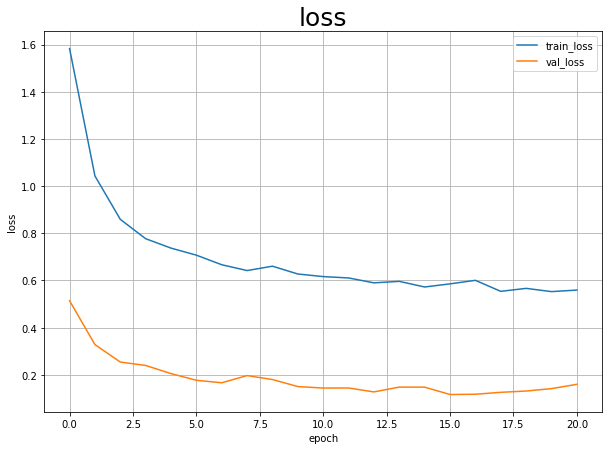

In [15]:
plt.figure(figsize=(10,7))
plt.grid()
plt.plot(loss_plot, label='train_loss')
plt.plot(val_loss_plot, label='val_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('loss', fontsize=25)
plt.legend()
plt.show()

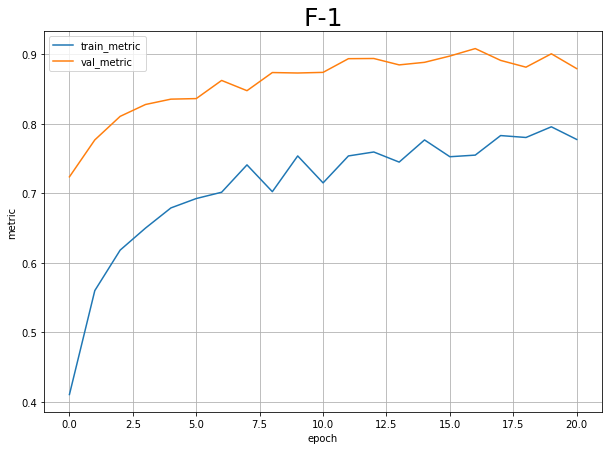

In [16]:
plt.figure(figsize=(10, 7))
plt.grid()
plt.plot(metric_plot, label='train_metric')
plt.plot(val_metric_plot, label='val_metric')
plt.xlabel('epoch')
plt.ylabel('metric')
plt.title("F-1", fontsize=25)
plt.legend()
plt.show()

# test Dataset 정의

In [13]:
val_transforms = A.Compose([
    A.Resize(224,224)
])

test = sorted(glob('data/test/*'))
test_dataset = CustomDataset(test, val_transforms, mode = 'test')
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [14]:
import torch.nn.functional as F

def softvoting(models, img, n_classes=25) :

    predicts = torch.zeros(img.size(0), n_classes)
    with torch.no_grad() :
        for model in models :
            output = model(img)
            output = F.softmax(output.cpu(), dim=1)
            predicts += output

    # 둘다 값은 똑같이 나옴.
    # pred_avg = predicts / len(models)
    # answer = pred_avg.argmax(dim=-1)
    # _, answer2 = torch.max(pred_avg, 1)

    return predicts.detach().cpu() / len(models)

In [15]:
def predict(dataset, models) :
    tqdm_dataset = tqdm(enumerate(dataset))
    results = []
    for batch, batch_item in tqdm_dataset :
        img = batch_item['img'].to(device)
#         print(img.shape)
        predictions = softvoting(models, img)
        batch_result = [int(torch.argmax(prediction)) for prediction in predictions]
#         print(batch_result)
#         for prediction in predictions :
            
#         results.append(int(torch.argmax(predictions[0])))
#             output = model(img)
#         output = torch.tensor(torch.argmax(output, dim=1), dtype=torch.int32).cpu().numpy()
        results.extend(batch_result)
    return results

kfold_models_path = glob('./model/k_fold_50k_pretrained_deit/*.pt')
models = []
for kfold_model_path in kfold_models_path :
    model = Deit(model_path)
    model.load_state_dict(torch.load(kfold_model_path, map_location=device))
    model.to(device).eval()
    models.append(model)

    
preds = predict(test_dataloader, models)




3245it [13:46,  3.92it/s]


In [16]:
preds_cp = preds

# Submission 만들기

In [17]:
preds_cp = np.array([train_label_decoder[int(val)] for val in preds_cp])
submission_csv = pd.read_csv('./data/sample_submission.csv')
submission_csv['label'] = preds_cp
submission_csv.to_csv('./data/k_public_vill_50k_pretrain_Deit_S16patch224_25E.csv', index=False)


In [ ]:

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()